In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
import os

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
from sklearn.datasets import load_digits
digits = load_digits()
from sklearn.datasets import make_blobs

# 教師なし学習
2種類の教師なし学習がある．
- データセットの教師なし変換
- クラスタリング

教師なし変換は，よりわかりやすい新しいデータ表現をつくるもの，次元削減やデータの構成や成分をみつけるものがある．  
クラスタリングはデータを似たような要素から構成されるグループにわける．  



## 教師なし変換
### 前処理
前処理も，教師なし変換といえる．  
前処理の種類
- StandardScaler
- RobustScaler
- MinMaxScaler
- Normalizer  
がある．

StandardScalerは平均0，分散1になるように変換する．  

RobustScalerは中央値と四分位数をそろえるように変換する．  
そろえ方は，データから中央値を引き，四分位範囲でわる方法である．  
外れ値に影響されにくい．

MinMaxScalerは最小値0最大値1になるように変換する．  

Normalizerは特徴量ベクトルがユークリッド長1になるように変換する．  
つまり，ベクトルの長さは1にして，方向成分のみが特徴量として残るようにする方法である．

In [4]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                    random_state=1)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 主成分分析（PCA）
PCAはまず最も分散が大きい方向をみつけ，その方向を第1成分とする．  
次に，第1成分に対して直交する方向の中から最も情報をもっている方向を探す．  
これを続けていくのがPCAである．  
もとのデータの次元数（特徴量の数）を，情報を保持したまま削減できるのが利点である．（図左下）  
また次元数を削除し，その次元数をもとに戻すと，ノイズが無くなる（図右下）

#### PCAで次元削減

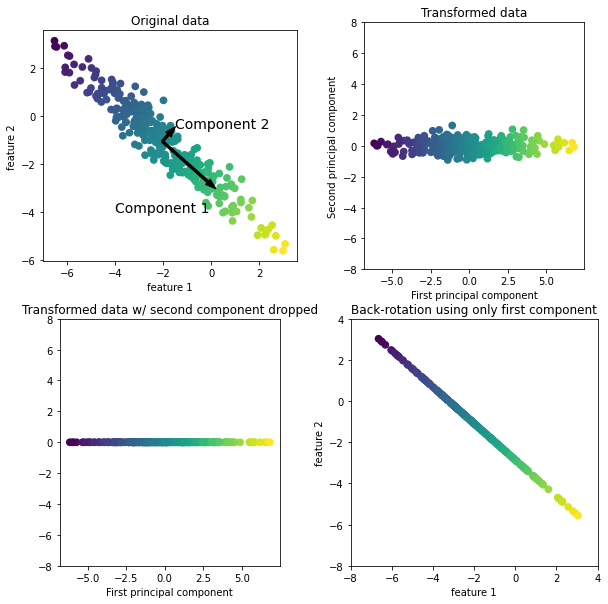

In [6]:
mglearn.plots.plot_pca_illustration()

#### PCAの2成分で図示

Text(0, 0.5, 'Second principal component')

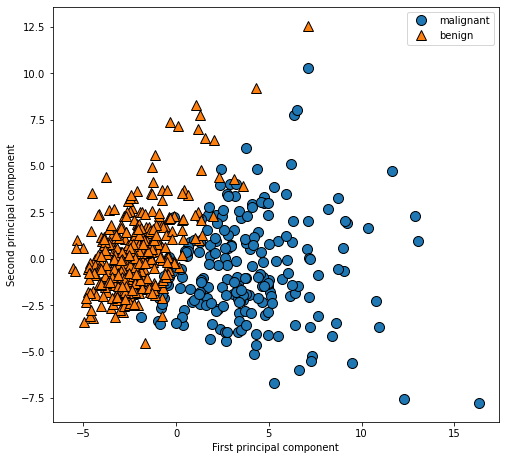

In [9]:
scaler = StandardScaler()
scaler.fit(cancer.data)
X_scaled = scaler.transform(cancer.data)

pca = PCA(n_components=2)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

plt.figure(figsize=(8, 8))
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], cancer.target)
plt.legend(cancer.target_names, loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

## 画像をPCAを使って分類

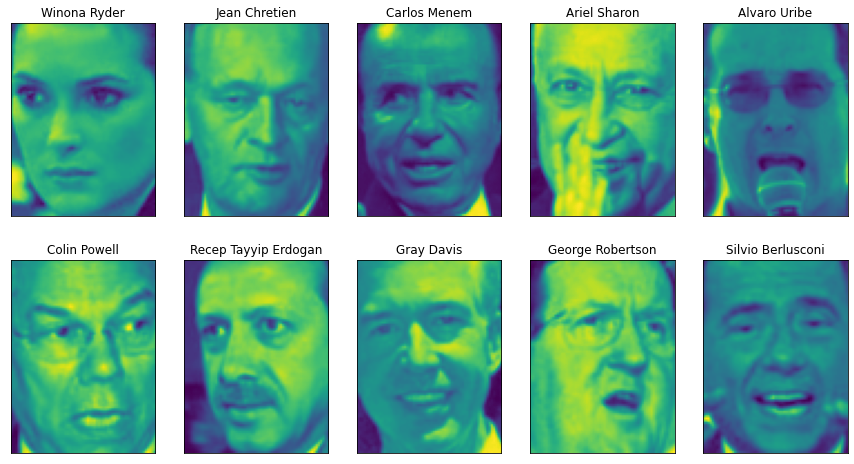

In [15]:
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)

image_shape = people.images[0].shape

fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

### データ数をそろえる 

In [16]:
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
X_people = people.data[mask]
y_people = people.target[mask]

X_people = X_people / 255.

<ipython-input-16-83da0c2157b6>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(people.target.shape, dtype=np.bool)


### PCAを使って精度向上

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X_people, y_people, stratify=y_people, random_state=0)
pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)
print("Test set accuracy: {:.2f}".format(knn.score(X_test_pca, y_test)))

Test set accuracy: 0.31


C:\Users\S2\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


## 非負値行列因子分解（NMF）
NMFは，係数と成分が0以上というルールのもと，複数の成分に分解する．  
よって，個々の特徴量が非負のデータにしか適用できない．　　

NMFは，複数の人が話している音声データや音楽を分解するのが得意である．  
また，成分の数が異なると，成分の方向が異なる．  

C:\Users\S2\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
C:\Users\S2\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


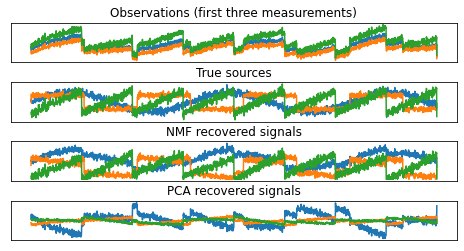

In [31]:
S = mglearn.datasets.make_signals()
A = np.random.RandomState(0).uniform(size=(100, 3))
X = np.dot(S, A.T)
nmf = NMF(n_components=3, random_state=42)
S_ = nmf.fit_transform(X)
pca = PCA(n_components=3)
H = pca.fit_transform(X)

models = [X, S, S_, H]
names = ['Observations (first three measurements)',
         'True sources',
         'NMF recovered signals',
         'PCA recovered signals']

fig, axes = plt.subplots(4, figsize=(8, 4), gridspec_kw={'hspace': .5},
                         subplot_kw={'xticks': (), 'yticks': ()})

for model, name, ax in zip(models, names, axes):
    ax.set_title(name)
    ax.plot(model[:, :3], '-')

#### PCAはデータ中の最も分散が大きい方向群を見出す
#### NMFは足しこんでいくことのできる成分を見つける

### t-SNEを用いた多様体学習
2次元表現をみつけるアルゴリズム．  
まずランダムな2次元表現を作り，もとの特徴空間で近いデータポンとを近く，遠いデータポイントを遠くに配置．　　

Text(0, 0.5, 't-SNE feature 1')

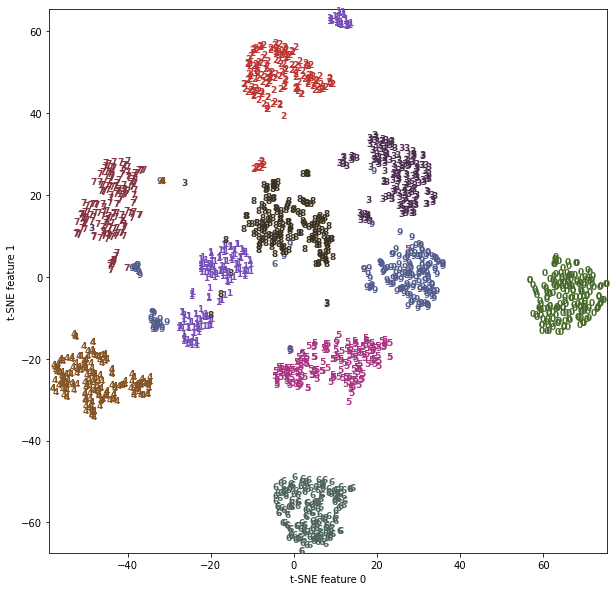

In [37]:
tsne = TSNE(random_state=42)
digits_tsne = tsne.fit_transform(digits.data)

plt.figure(figsize=(10, 10))
plt.xlim(digits_tsne[:, 0].min(), digits_tsne[:, 0].max() + 1)
plt.ylim(digits_tsne[:, 1].min(), digits_tsne[:, 1].max() + 1)

colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]

for i in range(len(digits.data)):
    plt.text(digits_tsne[i, 0], digits_tsne[i, 1], str(digits.target[i]),
             color = colors[digits.target[i]],
             fontdict={'weight': 'bold', 'size': 9})

plt.xlabel("t-SNE feature 0")
plt.ylabel("t-SNE feature 1")

## クラスタリング
クラスタリングはデータセットを「クラスタ」とよばれるグループに分割するタスクである．  
個々のデータポイントにその点が属するクラスタを表す数字を割り当てる.  

クラスタリングの種類
- k-means
- x-means

## k-means
データの領域を代表する重心をみつける方法．  

まず，個々のデータを最寄りの重心に割り当てる．  
次に，重心を割り当てられたデータの平均に設定する．  
データの割り当てが変化しなくなったらアルゴリズムは終了する．

k-meansの使いかた  
まずクラスのインスタンスを生成し，作りたいクラスタの数を設定する．  
次にデータに対してfitメソッドを呼ぶ．  

In [40]:
X, y = make_blobs(random_state=1)

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
print("Cluster memberships:\n{}".format(kmeans.labels_))

Cluster memberships:
[0 2 2 2 1 1 1 2 0 0 2 2 1 0 1 1 1 0 2 2 1 2 1 0 2 1 1 0 0 1 0 0 1 0 2 1 2
 2 2 1 1 2 0 2 2 1 0 0 0 0 2 1 1 1 0 1 2 2 0 0 2 1 1 2 2 1 0 1 0 2 2 2 1 0
 0 2 1 1 0 2 0 2 2 1 0 0 0 0 2 0 1 0 0 2 2 1 1 0 1 0]


k-meansがうまくいかないこともある．  
リング状などのクラスタを正しく識別できない．
それはk-meansではクラスタが凸の形状になっている，つまり球状のクラスタであることを前提としているため

Text(0, 0.5, 'Feature 1')

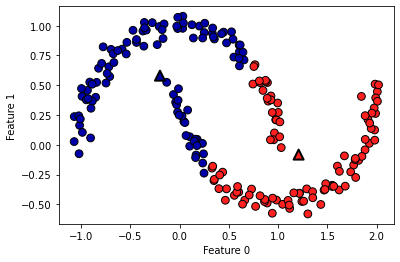

In [43]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
y_pred = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap=mglearn.cm2, s=60, edgecolor='k')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            marker='^', c=[mglearn.cm2(0), mglearn.cm2(1)], s=100, linewidth=2,
            edgecolor='k')
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

これを解決する方法の1つとして，kを増やし，2次元から10次元のデータとする方法がある．

Cluster memberships:
[9 2 5 4 2 7 9 6 9 6 1 0 2 6 1 9 3 0 3 1 7 6 8 6 8 5 2 7 5 8 9 8 6 5 3 7 0
 9 4 5 0 1 3 5 2 8 9 1 5 6 1 0 7 4 6 3 3 6 3 8 0 4 2 9 6 4 8 2 8 4 0 4 0 5
 6 4 5 9 3 0 7 8 0 7 5 8 9 8 0 7 3 9 7 1 7 2 2 0 4 5 6 7 8 9 4 5 4 1 2 3 1
 8 8 4 9 2 3 7 0 9 9 1 5 8 5 1 9 5 6 7 9 1 4 0 6 2 6 4 7 9 5 5 3 8 1 9 5 6
 3 5 0 2 9 3 0 8 6 0 3 3 5 6 3 2 0 2 3 0 2 6 3 4 4 1 5 6 7 1 1 3 2 4 7 2 7
 3 8 6 4 1 4 3 9 9 5 1 7 5 8 2]


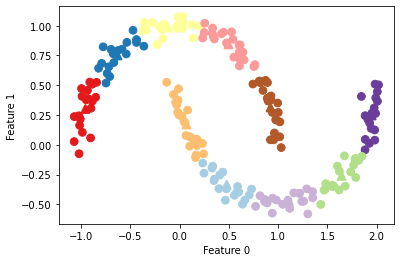

In [44]:
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(X)
y_pred = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=60, cmap='Paired')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=60,
            marker='^', c=range(kmeans.n_clusters), linewidth=2, cmap='Paired')
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
print("Cluster memberships:\n{}".format(y_pred))

## 利点と欠点


利点
- 理解しやすい
- 実装しやすい
- 高速に実行できる
大規模なデータセットを処理できるMiniBatchKMeansも用意されている．

欠点
- 初期化が乱数で行われる
- クラスタの形に対して制約の強い仮定をおいている
- クラスタ数を指定しなければならない

## 凝集型クラスタリング
個々のデータポイントをそれぞれ個別のクラスタとして開始し，最も類似した2つのクラスタを併合する．  
指定した数のクラスタだけが残るまで似たクラスタを併合し続ける．  
最も類似したと判定する方法は以下  
- ward
- average
- complete  

wardは分散が最小になるように選択する．  
averageはクラスタ間のすべてのポイント間の距離の平均値が最小の2クラスタを併合する．  
completeはクラスタの距離の最大値が最小となるものを併合する．  

Text(0, 0.5, 'Feature 1')

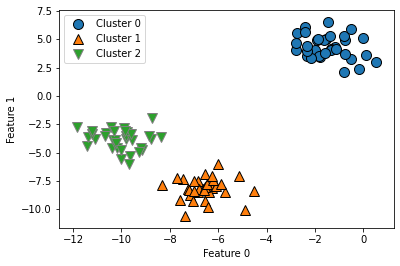

In [45]:
from sklearn.cluster import AgglomerativeClustering
X, y = make_blobs(random_state=1)

agg = AgglomerativeClustering(n_clusters=3)
assignment = agg.fit_predict(X)

mglearn.discrete_scatter(X[:, 0], X[:, 1], assignment)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

## DBSCAN
クラスタ数を先験的に与える必要がない．  
実行速度は比較的遅いが，大きいデータセットにも適用できる．  

DBSCANの仕組み  
まず，多くの点が近接しているような高密度領域をみつける．  
次に，高密度領域の中にあるデータの周りにある距離以上でデータが沢山あれば，そのデータはコアサンプルと呼ばれる
．  
そのコアサンプルに新しいクラスタラベルが割り当てられ，その周りのデータがまだクラスタに割り当てられていなければ，新しいクラスタラベルを割り当てる．  
ただし，周りのデータが既にコアサンプルの場合はクラスタは割り当てられず，違う周りのデータのサーチをする．  

全てのデータに対して以上の処理が終われば3種類のデータポイントができる．
- コアポイント
- 境界ポイント（周りのデータ）
- ノイズ（どちらにも属さないデータ）

境界ポイントは，どのデータから処理が始まるかによって変化するが，そこまで問題ではない．

Text(0, 0.5, 'Feature 1')

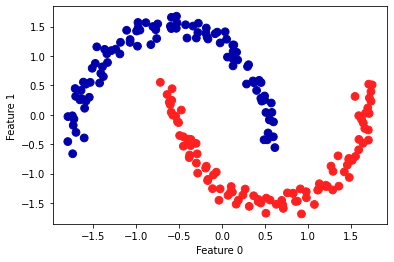

In [48]:
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

dbscan = DBSCAN()
clusters = dbscan.fit_predict(X_scaled)

plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm2, s=60)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")